In [1]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward1 as ak
import pandas as pd
import numpy as np
import seaborn as sns


#===========================================load config file====================================================================
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from utils import *

import yaml
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)
config = {}
with open("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16.yml") as f:
    config = yaml.safe_load(f)

outfilepath = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/ttoutfile"
year = '2016'; cat='net'
#==================================================set plot color==================================================
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)
#=================================================================================================================================================================================================
#=================================================================================================================================================================================================
#=================================================================================================================================================================================================
bkg_array,signal_array,data_array,sumWeight = extractCutedBranch(config,year,cat)

##===================================================================================================================================================================
def Conditional_norm_2Dhisto(h,nbins):
    temp_h = h
    for bin in range(0,nbins):
        nevents = temp_h[bin,:].values(flow=False).sum()
        if(nevents==0.0): continue
        #temp_h.view(flow=False).value[bin,:]  = np.nan_to_num(temp_h.view(flow=False).value[bin,:],0.0)
        temp_h.view(flow=False).value[bin,:] = temp_h.view(flow=False).value[bin,:]/nevents
    return temp_h

usage: ipykernel_launcher.py [-h] [-y YEAR] [-c CAT]
ipykernel_launcher.py: error: unrecognized arguments: -f /afs/ihep.ac.cn/users/g/guojl/.local/share/jupyter/runtime/kernel-bfae9cf3-6bd0-4efb-8ef7-be2992049314.json


SystemExit: 2

/cms/user/guojl/miniconda/envs/uprootframe/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
massZZ_low_bins = np.linspace(500,1700,25)
#massZZ_high_bins = np.array([2000,3500])
massZZ_high_bins = np.array([2000,4000])
massZZ_bins = bh.axis.Variable(ak.from_numpy(np.append(massZZ_low_bins,massZZ_high_bins)).to_list())
regions = ['CR','SR']
#reg = 'SR'
print(f'massZZ bins = {massZZ_bins}')

if(cat=='ak4'):
    massZZ='mass2l2jet'; kd = 'KD_Zjj'; case= 'resolved'
elif(cat=='net'):
    massZZ='mass2l2jet'; kd = 'KD_ZJ'; case='merged'

Alph_path = f'/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile/AlphaRaioVaildation_{case}.root'
Alph_array = uproot.lazy([f"{Alph_path}:alphatree"])

nbins, xmin, xmax = config['bininfo'][kd][0], config['bininfo'][kd][1], config['bininfo'][kd][2]
with uproot.recreate(f'FitTemplate/template_{case}_{year}.root') as outfile:
    cat = '2lep'
    bkg_hists = {}; Data_hist = {}; signal_hists = {}
    for reg in regions:
        bkg_hists[reg] = {}; Data_hist[reg] = {}; signal_hists[reg] = {}
        bkg_hists[reg][cat] = [None,None,None]; Data_hist[reg][cat] = None; signal_hists[reg][cat] = {}
        signal_hists[reg][cat] = {'ggh':bh.Histogram(massZZ_bins,bh.axis.Regular(50, 0, 1),storage=bh.storage.Weight()),
                              'vbf':bh.Histogram(massZZ_bins,bh.axis.Regular(50, 0, 1),storage=bh.storage.Weight())}

        for sample in config['Samples_lists']:
            print(f"This is {sample} in {cat}")
            if sample!='Data':
                if sample.find('DY')!=-1 and reg=="CR": continue
                temp_array = bkg_array[reg][cat][sample]
                #retray weight and apply paritcleNet weight
                weights = (temp_array['EventWeight']*config['lumi'][year]*1000*config['samples_inf'][sample][1])/sumWeight[sample]

                if (sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L') and cat=='net':
                    sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)   
                else:
                    sf_Net = ak.ones_like(temp_array['EventWeight'])
                weights = weights*sf_Net


                #temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                temp_hist = bh.Histogram(massZZ_bins,bh.axis.Regular(50, 0, 1),storage=bh.storage.Weight())
                temp_hist.fill(temp_array[massZZ],temp_array[kd],weight = weights)
                
                if sample.find('DY')!=-1:
                    if (bkg_hists[reg][cat])[2]==None:
                        (bkg_hists[reg][cat])[2] = temp_hist
                    else:
                        (bkg_hists[reg][cat])[2]+=temp_hist
                if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                    if (bkg_hists[reg][cat])[1]==None:
                        (bkg_hists[reg][cat])[1] = temp_hist
                    else:
                        (bkg_hists[reg][cat])[1]+=temp_hist
                if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                    if (bkg_hists[reg][cat])[0]==None:
                        (bkg_hists[reg][cat])[0] = temp_hist
                    else:
                        (bkg_hists[reg][cat])[0]+=temp_hist
            else:
                temp_array = data_array[reg][cat]
                weights = np.ones_like(temp_array['EventWeight'])
                print(f'data weight  = {weights}')
                #Data_hist[reg][cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                Data_hist[reg][cat] = bh.Histogram(massZZ_bins,bh.axis.Regular(50, 0, 1),storage=bh.storage.Weight())
                Data_hist[reg][cat].fill(temp_array[massZZ],temp_array[kd],weight=weights)
                #Data_hist[reg][cat] = temp_hist

        if(year!='2016APV' and year!='2017'):
            for sample in config['signal_lists']:
                temp_array = signal_array[reg][cat][sample]
                if year=='2016': 
                    weights = (temp_array['EventWeight']*36.33*1000*config['samples_inf'][sample][1])/sumWeight[sample]
                else:
                    weights = (temp_array['EventWeight']*config['lumi'][year]*config['samples_inf'][sample][1])/sumWeight[sample]
                if cat=='net':
                    sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal) 
                else:
                    sf_Net = ak.ones_like(temp_array['EventWeight'])
                weights = weights*sf_Net

                temp_hist = bh.Histogram(massZZ_bins,bh.axis.Regular(50, 0, 1),storage=bh.storage.Weight())
                temp_hist.fill(temp_array[massZZ],temp_array[kd],weight = weights)

                if sample.find('ggh')!=-1:
                    signal_hists[reg][cat]['ggh'] = signal_hists[reg][cat]['ggh']+temp_hist
                elif sample.find('vbf')!=-1:
                    signal_hists[reg][cat]['vbf'] = signal_hists[reg][cat]['vbf']+temp_hist

This is DY_pt50To100 in 2lep
This is DY_pt100To250 in 2lep
This is DY_pt250To400 in 2lep
This is DY_pt400To650 in 2lep
This is DY_pt650ToInf in 2lep
This is TTJets in 2lep
This is WZTo2Q2L in 2lep
This is ZZTo2Q2L in 2lep
This is WWTo2L2Nu in 2lep
This is Data in 2lep
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This is DY_pt50To100 in 2lep
This is DY_pt100To250 in 2lep
This is DY_pt250To400 in 2lep
This is DY_pt400To650 in 2lep
This is DY_pt650ToInf in 2lep
This is TTJets in 2lep
This is WZTo2Q2L in 2lep
This is ZZTo2Q2L in 2lep
This is WWTo2L2Nu in 2lep
This is Data in 2lep
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## TEST

In [20]:
def Conditional_norm_2Dhisto(h,nbins):
    temp_h = h
    for bin in range(0,nbins):
        nevents = temp_h.values(flow=False).sum()
        temp_h.view(flow=False).value[bin,:] = temp_h.view(flow=False).value[bin,:]/nevents
    return temp_h

### Z+jet

In [4]:
Data_hist['CR']['2lep'].view(flow=False).value[0,:]

array([3.596e+03, 2.070e+02, 5.800e+01, 1.700e+01, 1.100e+01, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

In [5]:
Data_hist['SR']['2lep'].view(flow=False).value[0,:]

array([348., 238., 175., 140., 114., 128.,  90.,  79.,  71.,  57.,  58.,
        63.,  58.,  50.,  55.,  49.,  66.,  51.,  73.,  70.])

In [6]:
Data_hist['CR']['2lep'].view(flow=False).value[0,:] = bkg_hist['SR']['2lep'][2].view(flow=False).value[0,:]
Data_hist['CR']['2lep'].view(flow=False).value[0,:]

array([348., 238., 175., 140., 114., 128.,  90.,  79.,  71.,  57.,  58.,
        63.,  58.,  50.,  55.,  49.,  66.,  51.,  73.,  70.])

In [11]:
xbins = Data_hist['CR']['2lep'].axes.size[0]
xbins

26

In [16]:
for x in range(0,xbins):
    Data_hist['CR']['2lep'].view(flow=False).value[x,:] = bkg_hists['SR']['2lep'][2].view(flow=False).value[x,:]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2c44daf7c0>, errorbar=None, legend_artist=None)]

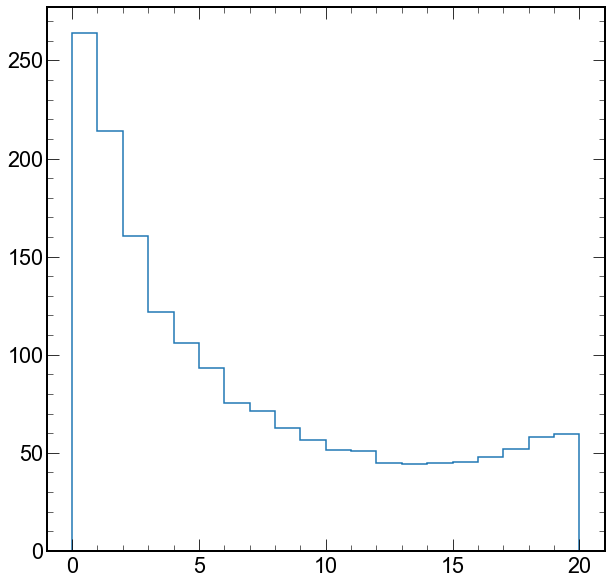

In [17]:
hep.histplot(Data_hist['CR']['2lep'].view(flow=False).value[0,:])

In [21]:

reg='SR'

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f2b3500fee0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f2b35020340>, text=[])

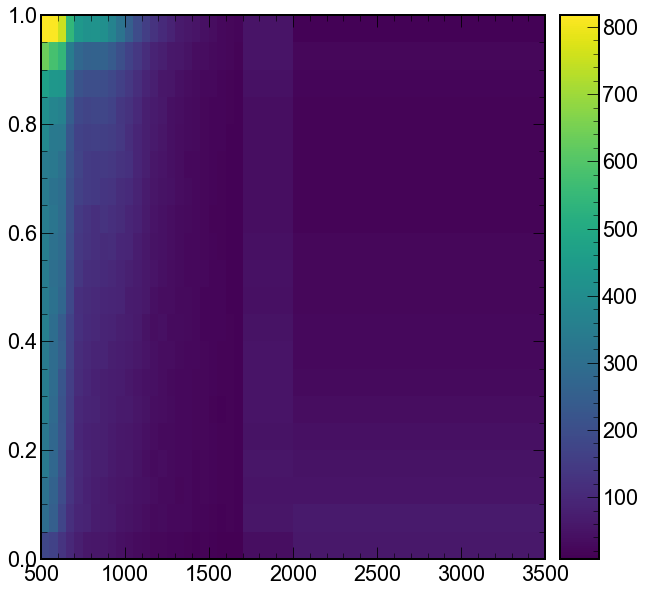

In [12]:
sig_hist = (signal_hists[reg][cat]['ggh']+signal_hists[reg][cat]['vbf'])
hep.hist2dplot(sig_hist)

In [24]:
nevents = sig_hist.view(flow=False).value.sum()
nevents

52635.147334788926

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f947f8a2fd0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f947f8ae310>, text=[])

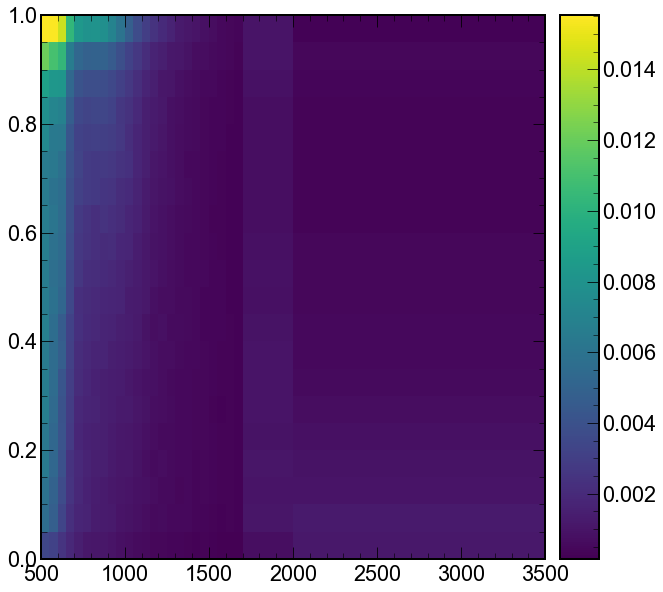

In [26]:
sig_hist.view(flow=False).value = sig_hist.view(flow=False).value*weight_one
hep.hist2dplot(sig_hist)

In [30]:
sig_hist.axes.size[0]

26

In [36]:
sig_hist[0,:].values(flow=False).sum()

7651.110458116047

In [38]:
for i in range(0,26):
    nevents = sig_hist[i,:].values(flow=False).sum()
    sig_hist.view(flow=False).value[i,:] = sig_hist.view(flow=False).value[i,:]/nevents

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f2b349f0340>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f2b34a6efa0>, text=[])

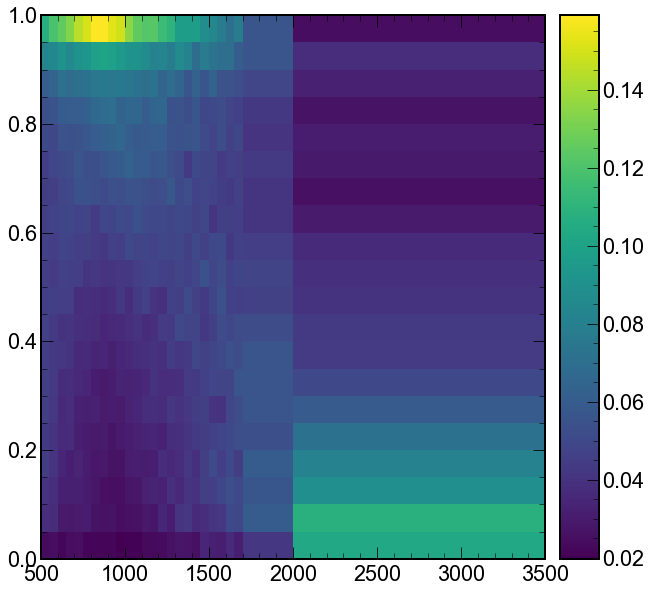

In [39]:
hep.hist2dplot(sig_hist)

In [ ]:
Data_hist['CR']['2lep'].sum(flow=False)

In [18]:
massZZ_bins.size

26